In [1]:
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
import numpy as np
import qc_utils as qcu
from ansatz import HE_ansatz,fixed_ansatz

from qiskit.quantum_info import SparsePauliOp, Operator,Pauli
from qiskit.circuit.gate import Gate
from scipy.optimize import minimize

from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.quantum_info import DensityMatrix, Statevector

from qiskit.circuit.library import HGate

In [2]:
def get_beta_lm(qc_ansatz,A_LCU,l,m,**kwargs):
    """
    This function is used to calculate the terms for evaluating the norm of |psi> = A |\tilde{x}> =  AV|0>, where V is ansatz. 
    A = \sum_{m} a_l A_l.  
    <psi|psi> = \sum_{lm} a_m* a_l beta_{lm}
    beta_{lm} = <0|V^T A_{m}^T A_{l} V |0>  
    """
    
    assert isinstance(A_LCU,SparsePauliOp), "A_LCU must be SparsePauliOp"
    assert isinstance(qc_ansatz,(QuantumCircuit,Gate)), "qc_ansatz must be from (QuantumCircuit,Gate)"
    assert isinstance(l,int) and isinstance(m,int), "l and m must be int" 
    assert l < len(A_LCU) and m < len(A_LCU), "l and m must be less than len(A_LCU)"
   
    A_l, A_m = A_LCU[l].paulis[0], A_LCU[m].paulis[0]

    if (l == m):
        beta_lm = 1
        return beta_lm

    V_gate = qcu.make_gate(qc_ansatz,label='V')
    name_l, name_m = str(A_l), str(A_m)+"^T"
    
    A_l_gate = qcu.make_gate(A_l,label=name_l)
    A_m_dagger_gate = qcu.make_gate(A_m.inverse(),label=name_m)

    beta_lm_real = qcu.hadamard_test(V_gate, [A_m_dagger_gate,A_l_gate],**kwargs)
    beta_lm_imag = qcu.hadamard_test(V_gate, [A_m_dagger_gate,A_l_gate],imag=True,**kwargs)
    beta_lm = beta_lm_real + 1j* beta_lm_imag
    return beta_lm


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_42220/2025530787.py:2: SyntaxWarning: invalid escape sequence '\s'
  """


In [3]:
def get_gamma_lm(qc_ansatz,B_gate,A_LCU,l,m,**kwargs):
    """
    This function is used to calculate the terms in evaluating |<b|psi>|^2 = |<0|B^T A V |0>|^2 = \sum_{lm} a_m* a_l gamma_{lm}. 
    A = \sum_{m} a_l A_l.  
    gamma_{lm} = <0|B^T A_{l} V |0> <0|V^T A_{m}^T B |0> 
    """
    
    assert isinstance(A_LCU,SparsePauliOp), "A_LCU must be SparsePauliOp"
    assert isinstance(qc_ansatz,(QuantumCircuit,Gate)), "qc_ansatz must be from (QuantumCircuit,Gate)"
    assert isinstance(B_gate,Gate),  "B must be a gate"
    assert isinstance(l,int), "l must be int" 
    assert isinstance(m,int), "m must be int" 
    assert l < len(A_LCU), "l must be less than len(A_LCU)"
    assert m < len(A_LCU), "m must be less than len(A_LCU)"   
    assert len(set([A_LCU.num_qubits,qc_ansatz.num_qubits,B_gate.num_qubits])) == 1, "dimensions of A_LCU, qc_ansatz and B must be same"

    n = A_LCU.num_qubits

    A_l, A_m = A_LCU[l].paulis[0], A_LCU[m].paulis[0]
    
    V_gate = qcu.make_gate(qc_ansatz,label='V')
    V_dagger_gate = qcu.make_gate(V_gate.inverse(), label = 'V^T')
    B_dagger_gate = qcu.make_gate(B_gate.inverse(), label = 'B^T')

    name_l, name_m = str(A_l), str(A_m)+"^T"
    
    A_l_gate = qcu.make_gate(A_l,label=name_l)
    A_m_dagger_gate = qcu.make_gate(A_m.inverse(),label=name_m)

    if (l == m):
        
        qc = QuantumCircuit(n)
        qc.append(V_gate,[i for i in range(n)])
        qc.append(A_l_gate,[i for i in range(n)])
        qc.append(B_dagger_gate,[i for i in range(n)])
        
        ideal = kwargs.get("ideal",False)
        draw_circuit = kwargs.get("draw_circuit", False) 

        if ideal:
             if draw_circuit:
                print(qc.draw(fold = -1))
             dm = DensityMatrix(qc)
             probs = dm.probabilities()
             gamma_lm = probs[0]
             return gamma_lm

        qc.measure_all()
        
        
        if draw_circuit:
                print(qc.draw(fold = -1))

        backend = AerSimulator()
        pass_manager = generate_preset_pass_manager(backend=backend ,optimization_level=0)
        qc_transpiled_list = [pass_manager.run(qc)]

        sampler = Sampler()
        num_shots = 1024*100
        result = sampler.run(qc_transpiled_list, shots=num_shots).result()[0]
        gamma_l = result.data.meas.get_counts().get('0'*n,0)/ result.data.meas.num_shots
        gamma_lm = gamma_l

        return gamma_lm

    I_gate = qcu.make_gate(np.eye(2**n),label='I') 
    
    gamma_l_real = qcu.hadamard_test(U_psi=I_gate,Us=[V_gate,A_l_gate,B_dagger_gate],**kwargs)
    gamma_l_imag = qcu.hadamard_test(U_psi=I_gate,Us=[V_gate,A_l_gate,B_dagger_gate],imag=True,**kwargs)
    gamma_m_real =  qcu.hadamard_test(U_psi=I_gate,Us=[B_gate,A_m_dagger_gate,V_dagger_gate],**kwargs)
    gamma_m_imag =  qcu.hadamard_test(U_psi=I_gate,Us=[B_gate,A_m_dagger_gate,V_dagger_gate],imag=True,**kwargs)

    gamma_l = gamma_l_real + 1j*gamma_l_imag
    gamma_m = gamma_m_real + 1j*gamma_m_imag

    gamma_lm = gamma_l*gamma_m

    return gamma_lm

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_42220/3426428963.py:2: SyntaxWarning: invalid escape sequence '\s'
  """


In [4]:
def hadamard_overlap_test_circuit(qc_ansatz,B_gate,A_LCU,l,m,imag=False,ideal=True):
    assert isinstance(A_LCU,SparsePauliOp), "A_LCU must be SparsePauliOp"
    assert isinstance(qc_ansatz,(QuantumCircuit,Gate)), "qc_ansatz must be from (QuantumCircuit,Gate)"
    assert isinstance(B_gate,Gate),  "B must be a gate"
    assert isinstance(l,int), "l must be int" 
    assert isinstance(m,int), "m must be int" 
    assert l < len(A_LCU), "l must be less than len(A_LCU)"
    assert m < len(A_LCU), "m must be less than len(A_LCU)"   
    assert len(set([A_LCU.num_qubits,qc_ansatz.num_qubits,B_gate.num_qubits])) == 1, "dimensions of A_LCU, qc_ansatz and B must be same"

    n = qc_ansatz.num_qubits

    V_gate = qcu.make_gate(qc_ansatz,label='V')

    A_l, A_m = A_LCU[l].paulis[0], A_LCU[m].paulis[0]
    name_l, name_m = str(A_l), str(A_m)+"^T"
    A_l_gate = qcu.make_gate(A_l,label=name_l)
    A_m_dagger_gate = qcu.make_gate(A_m.inverse(),label=name_m)
    control_A_l_gate = A_l_gate.control(1)
    control_A_m_dagger_gate = A_m_dagger_gate.control(1)

    ancilla = QuantumRegister(1,'a')
    s1 = QuantumRegister(n,'s1')
    s2 = QuantumRegister(n,'s2')
    qc = QuantumCircuit(ancilla,s1,s2)
    qc.h(ancilla[0])
    qc.append(V_gate,[s1[i] for i in range(n)])
    qc.append(B_gate,[s2[i] for i in range(n)])
    qc.append(control_A_l_gate, [ancilla[0]] + [s1[i] for i in range(n)])
    qc.append(control_A_m_dagger_gate, [ancilla[0]] + [s2[i] for i in range(n)])
    if imag:
        qc.rz(-np.pi/2,ancilla[0])
    qc.h(ancilla[0])
    for i in range(n):
        qc.cx(s1[i],s2[i])
        qc.h(s1[i])
    return qc

def postprocessing_hadamard_overlap_test(counts_dict,reverse = False):
    assert isinstance(counts_dict,dict), "counts dict must be a dictionary with keys as binary strings and values as counts"
    
    p_dict = {}
    den = sum(counts_dict.values())
    p_dict = dict(zip(counts_dict.keys(),list(counts_dict.values())/den))

    if reverse:
        p_dict = {}
        for key,value in counts_dict.items():
            r_key = key[::-1]
            p_dict[r_key] = value/den

    def get_c_x_individual_coeff(i,j):
        i = int(i)
        j = int(j)
        assert (i in (0,1) and j in (0,1)), "i,j must be binary"

        coeff = 1
        if i == 1 and j == 1:
            coeff = -1
        return coeff

    def get_C_coeff(key):
        assert isinstance(key,str)
        key = key[1:]
        n = len(key)//2
        coeff = 1
        for i in range(n):
            coeff *= get_c_x_individual_coeff(key[i],key[i+n])
        
        return coeff


    c_0 = 0
    c_1 = 0
    n = 3
    for key,value in p_dict.items():
        if key[0] == '0':
            for i in range(1,n+1):
                c_0 += get_C_coeff(key)*value
        else:
            for i in range(1,n+1):
                c_1 += get_C_coeff(key)*value

    return c_0,c_1
    

In [5]:
def local_hadamard_test(qc_ansatz,B_gate,A_LCU,l,m,j,imag = False,ideal=False,shots = 1024,draw_circuit=False):
    """
    This function is used to evaluate the terms of the local Hamiltonian cost function.
    delta_{lm}^(j) = <0|V^T A_m^T B (Z_j \tensor I_j_bar) B^T A_l V|0>.
    """

    assert isinstance(A_LCU,SparsePauliOp), "A_LCU must be SparsePauliOp"
    assert isinstance(qc_ansatz,(QuantumCircuit,Gate)), "qc_ansatz must be from (QuantumCircuit,Gate)"
    assert isinstance(B_gate, Gate), "B_gate must be of type Gate"
    assert isinstance(l,int) and isinstance(m,int) and isinstance(j,int), "l, m and j must be int" 
    assert l < len(A_LCU) and m < len(A_LCU), "l and m must be less than len(A_LCU)"
    assert len(set([A_LCU.num_qubits,qc_ansatz.num_qubits,B_gate.num_qubits])) == 1, "dimensions of A_LCU, qc_ansatz and B must be same"

    n_ = A_LCU.num_qubits
    assert j<n_, "j must be less than num_qubits"
    n = n_  + 1

    A_l, A_m = A_LCU[l].paulis[0], A_LCU[m].paulis[0]


    V_gate = qcu.make_gate(qc_ansatz,label='V')
    name_l, name_m = str(A_l), str(A_m)+"^T"
    
    A_l_gate = qcu.make_gate(A_l,label=name_l)
    A_m_dagger_gate = qcu.make_gate(A_m.inverse(),label=name_m)

    c_A_l_gate = qcu.make_control_gate(A_l_gate, 1)
    c_A_m_dagger_gate = qcu.make_control_gate(A_m_dagger_gate,1) 

    # c_B_gate = qcu.make_control_gate(B_gate,1,label='C-B')
    # c_B_dagger_gate = qcu.make_control_gate(B_gate.inverse(),1,label='C-B^T')
    B_dagger_gate = qcu.make_gate(B_gate.inverse(),label='B^T')
    qc = QuantumCircuit(n,1)
    qc.h(0)
    if imag:
        qc.sdg(0)
    qc.append(V_gate,[i for i in range(1,n)])
    qc.append(c_A_l_gate,[i for i in range(n)])
    qc.append(B_dagger_gate, [i for i in range(1,n)])
    # qc.append(c_B_dagger_gate,[i for i in range(n)])
    qc.cz(0,j+1)
    qc.append(B_gate, [i for i in range(1,n)])
    # qc.append(c_B_gate,[i for i in range(n)])
    qc.append(c_A_m_dagger_gate,[i for i in range(n)])
    qc.h(0)
    
    if ideal:
        if draw_circuit:
            print(qc.draw(fold=-1))

        dm = DensityMatrix(qc)
        probs_0 = dm.probabilities([0])
        expectation = probs_0[0] - probs_0[1]
   
    else:
        qc.measure(0, 0)
        
        if draw_circuit:
            print(qc.draw(fold=-1))
        
        backend = AerSimulator()
        pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=0)
        qc_transpiled = pass_manager.run(qc)
        
        sampler = Sampler()
        result = sampler.run([qc_transpiled], shots=shots).result()
        counts = result[0].data.c.get_counts()
        expectation = (counts.get('0', 0) - counts.get('1', 0)) / shots

    return expectation

In [6]:
def get_delta_lmj(qc_ansatz,B_gate,A_LCU,l,m,j,**kwargs):
    """
    This function is used to evaluate the terms of the local Hamiltonian cost function.
    delta_{lm}^(j) = <0|V^T A_m^T B (Z_j \tensor I_j_bar) B^T A_l V|0>.
    """
    
    assert isinstance(A_LCU,SparsePauliOp), "A_LCU must be SparsePauliOp"
    assert isinstance(qc_ansatz,(QuantumCircuit,Gate)), "qc_ansatz must be from (QuantumCircuit,Gate)"
    assert isinstance(B_gate, Gate), "B_gate must be of type Gate"
    assert isinstance(l,int) and isinstance(m,int) and isinstance(j,int), "l, m and j must be int" 
    assert l < len(A_LCU) and m < len(A_LCU), "l and m must be less than len(A_LCU)"
    assert len(set([A_LCU.num_qubits,qc_ansatz.num_qubits,B_gate.num_qubits])) == 1, "dimensions of A_LCU, qc_ansatz and B must be same"

    n_ = A_LCU.num_qubits
    assert j<n_, "j must be less than num_qubits"

    delta_real = local_hadamard_test(qc_ansatz,B_gate,A_LCU,l,m,j,**kwargs)
    delta_imag = local_hadamard_test(qc_ansatz,B_gate,A_LCU,l,m,j,imag=True,**kwargs)
    delta_lmj = delta_real + 1j*delta_imag
    
    return delta_lmj

In [7]:
def calculate_psi_norm(qc_ansatz,A_LCU,**kwargs):
    """ 
    This function evaluates the norm of the solution |psi>. |psi> = A|\tilde{x}> = AV|0>. 
    <psi|psi> = sum_{lm} a_m* a_l beta_{lm}
    beta_{lm} = <0|V^T A_{m}^T A_{l} V |0> 
    """

    assert isinstance(qc_ansatz, QuantumCircuit), "qc_ansatz must be a QuantumCircuit"
    assert isinstance(A_LCU,SparsePauliOp), "A_LCU must be a SparsePauliOp"
    assert len(set([A_LCU.num_qubits,qc_ansatz.num_qubits])) == 1, "dimensions of A_LCU and qc_ansatz must be same"

    coeffs = A_LCU.coeffs
    paulis = A_LCU.paulis

    inner_product = 0
    for i in range(len(A_LCU)):
        for j in range(i,len(A_LCU)):
            beta_ij = get_beta_lm(qc_ansatz,A_LCU,i,j,**kwargs)
            if i == j:
                inner_product += coeffs[j].conjugate()*coeffs[i]*beta_ij
            else:
                inner_product += coeffs[j].conjugate()*coeffs[i]*beta_ij
                inner_product += coeffs[i].conjugate()*coeffs[j]*beta_ij
    
    return inner_product

def calculate_inner_product_b_psi_squared(qc_ansatz,B_gate,A_LCU,**kwargs):
    """
    This function is used to evaluate |<b|psi>|^2 = |<0|B^T A V |0>|^2 = sum_{lm} a_m* a_l gamma_{lm}. 
    A = sum_{m} a_l A_l.  
    gamma_{lm} = <0|B^T A_{l} V |0> <0|V^T A_{m}^T B |0> 
    """
    assert isinstance(A_LCU,SparsePauliOp), "A_LCU must be SparsePauliOp"
    assert isinstance(qc_ansatz,(QuantumCircuit,Gate)), "qc_ansatz must be from (QuantumCircuit,Gate)"
    assert isinstance(B_gate,Gate),  "B must be a gate"
    assert len(set([A_LCU.num_qubits,qc_ansatz.num_qubits,B_gate.num_qubits])) == 1, "dimensions of A_LCU, qc_ansatz and B must be same"

    coeffs = A_LCU.coeffs

    inner_product = 0
    for i in range(len(A_LCU)):
        for j in range(len(A_LCU)):
            if i==j:
                gamma_ij = get_gamma_lm(qc_ansatz,B_gate,A_LCU,i,j,**kwargs)
                inner_product += coeffs[j].conjugate()*coeffs[i]*gamma_ij
            else:
                gamma_ij = get_gamma_lm(qc_ansatz,B_gate,A_LCU,i,j,**kwargs)
                inner_product += coeffs[j].conjugate()*coeffs[i]*gamma_ij
                
    return inner_product

In [8]:
local_cost_history = []
global_cost_history = []

def calculate_local_cost(params, ansatz, n, d, A_LCU, B_gate,**kwargs):
    """ 
    This function evaluate the local cost Hamiltonian.
    C_{L} = \frac{1}{2} - \frac{1}{2n} * \frac{sum_{lm} a_l a_m* sum_{j} delta_{lm}^(j)} {sum_{lm} a_l a_m* \beta_{lm}}.  
    """
    
    qc = ansatz(n, d, params)
    n = qc.num_qubits

    num = 0

    for i,l in enumerate(A_LCU):
        for j,m in enumerate(A_LCU):
            al = l.coeffs[0] 
            am = m.coeffs[0]

            for k in range(n):
                delta_ijk = get_delta_lmj(qc,B_gate,A_LCU,i,j,k,**kwargs)
                num += al*am.conjugate()*delta_ijk 

    den = calculate_psi_norm(qc,A_LCU,**kwargs)
    cost = (0.5 - 0.5*num/(n*den)).real
    local_cost_history.append(cost)
    print(cost)
    return cost

def calculate_global_cost(params, ansatz, n, d, A_LCU, B_gate, **kwargs):
    """
    This function evaluates the global cost Hamiltonian.
    C_{G} = 1 - \frac{|<b|psi>|^2}{<psi|psi>}
    C_{G} = 1 - \frac{sum_{lm} a_l a_m* gamma_{lm}} {sum_{lm} a_l a_m* \beta_{lm}}
    """
    qc = ansatz(n, d, params)
    den = calculate_psi_norm(qc_ansatz=qc, A_LCU=A_LCU,**kwargs)
    num = calculate_inner_product_b_psi_squared(qc_ansatz=qc, B_gate=B_gate, A_LCU=A_LCU,**kwargs)

    cost = np.squeeze(1  - (num/den)).real
    global_cost_history.append(cost)
    print(cost)

    return cost
            

In [9]:
# A = 0.55*SparsePauliOp('III') + 0.45*SparsePauliOp('IIZ')
A = SparsePauliOp('III') + 0.2*SparsePauliOp('XZI') + 0.2*SparsePauliOp('XII')
B = Operator(HGate()).expand(HGate()).expand(HGate())
B_gate = qcu.make_gate(B,label='B')

A_LCU = qcu.get_LCU(A)
A_LCU

SparsePauliOp(['III', 'XII', 'XZI'],
              coeffs=[1. +0.j, 0.2+0.j, 0.2+0.j])

In [10]:
def ansatz(n,d,params):
    qc =QuantumCircuit(n)
    for i in range(d):
        for j in range(n):
            qc.ry(params[i*n + j],j)

    return qc

In [11]:
# params = [i for i in range(9)]
params = [0 for i in range(6)]
n = 3
d = 2
qc_ansatz = fixed_ansatz(n,d,params)
qc_ansatz.draw()

┌───────┐   ┌───────┐               
q_0: ┤ Ry(0) ├─■─┤ Ry(0) ├──────────■────
     ├───────┤ │ └───────┘┌───────┐ │    
q_1: ┤ Ry(0) ├─■─────■────┤ Ry(0) ├─■──■─
     ├───────┤       │    ├───────┤    │ 
q_2: ┤ Ry(0) ├───────■────┤ Ry(0) ├────■─
     └───────┘            └───────┘

In [12]:
sol_local = minimize(
    lambda params: calculate_local_cost(params, fixed_ansatz, n, d, A_LCU, B_gate, ideal = True),
    params,
    method="COBYLA",
    options={'maxiter':100}
    )

0.38505747126436796
0.24481230712971874
0.1434738940152553
0.08706722116374921
0.14947050317711574
0.18685300944159522
0.1452817510209939
0.05924059635734702
0.18586447533384082
0.12203385290781366
0.11149950672438336
0.042340710305864226
0.036545863309329796
0.022816788507290964
0.03005934748791922
0.023551942169144024
0.035500023827263194
0.04008532229093109
0.027977172378726545
0.013403969195619536
0.017223323826472625
0.01819415869553348
0.0039081481450366495
0.0024804599271593952
0.004754213463613599
0.0026758818218829417
0.003756896145041766
0.0018721371264560638
0.0021049985827136797
0.005181512762449936
0.0013440362720338328
0.0016472123475445577
0.0007524471860850812
0.000532085021186568
0.0013168394867255628
0.0004946292669139596
0.00031518024377830134
0.0006280908268821439
0.00033493915037363653
0.0007033193713780195
0.00032880737601342913
0.0003231728561064462
0.0003629514629434616
0.0002500785538926964
0.0002163064393690961
0.0001511480859025527
0.00015652761701884232
0.00

In [13]:
sol_global = minimize(
    lambda params: calculate_global_cost(params, fixed_ansatz, n, d, A_LCU, B_gate, ideal = True),
    params,
    method="COBYLA",
    options={'maxiter':100}
    )

0.7887931034482756
0.6110686282086769
0.40213229632090375
0.24673114369251892
0.33542692226545656
0.3359424695664036
0.3519239074915884
0.05513378688366888
0.24663417177587854
0.2547577852982762
0.06589976516770935
0.06756988940583986
0.02433682514297475
0.002349655308003129
0.07745197849669194
0.020953982446481945
0.04348291954871597
0.007618764478211748
0.0054762857534336185
0.005032869485606217
0.0007648673149363017
0.0011361172358386185
0.005949116065403048
0.001761750215476643
0.004231095715298672
0.0019026130709925981
0.0014793252115556932
0.0004304345082819516
0.000529740831916925
0.0005598445194701096
0.0002975676545695638
0.0005398473525781711
0.0004496732705513429
8.862396243269899e-05
0.00029691185373459383
5.68055487902841e-05
0.0003688333353133455
7.37228454764649e-05
7.777939966346903e-05
5.344550142361015e-05
9.644312453305215e-05
7.992782640742213e-05
7.082668428792793e-05
5.756379513732757e-05
3.900154460889649e-05
3.891851594428619e-05
4.1769122258172864e-05
1.4246143

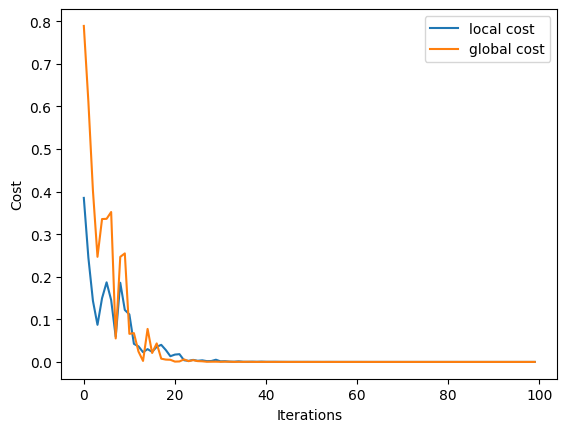

In [14]:
import matplotlib.pyplot as plt

plt.plot(local_cost_history, label = "local cost")
plt.plot(global_cost_history, label = "global cost")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.legend()
plt.show()

In [15]:
qc_sol_local = fixed_ansatz(n,d,sol_local.x)
qc_sol_global = fixed_ansatz(n,d,sol_global.x)

In [21]:
sv_qc_global = Statevector(qc_sol_global)
sv_qc_local = Statevector(qc_sol_local)

In [22]:
b = B.to_matrix()@np.array(list([1] + [0 for i in range(2**n-1)]))
x_exact = np.linalg.inv(A.to_matrix()) @ b
sv_x_exact = Statevector(x_exact)
sv_x_exact = sv_x_exact/np.sqrt(sv_x_exact.inner(sv_x_exact))

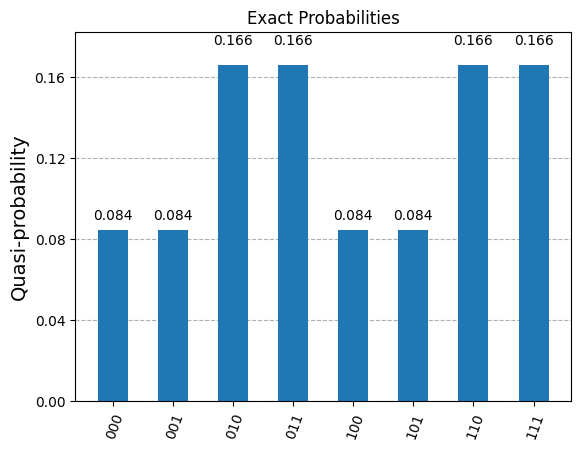

In [23]:
from qiskit.visualization import plot_histogram

plot_histogram(sv_x_exact.probabilities_dict(),title='Exact Probabilities')

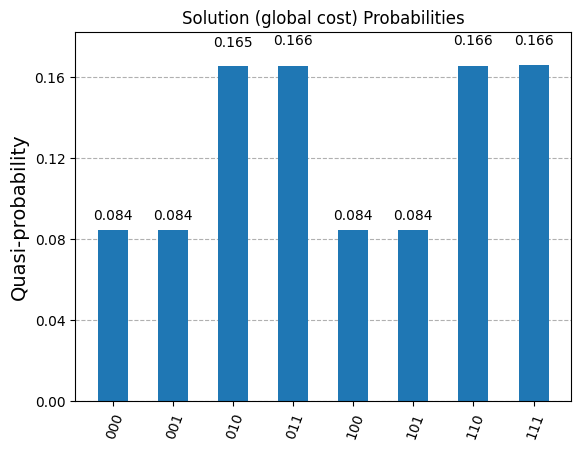

In [24]:
plot_histogram(sv_qc_global.probabilities_dict(),title='Solution (global cost) Probabilities')

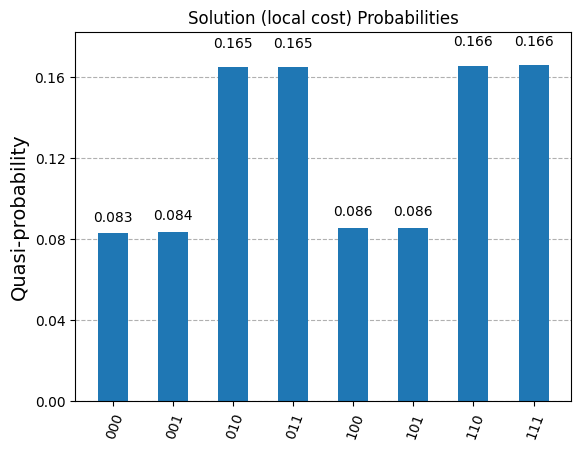

In [25]:
plot_histogram(sv_qc_local.probabilities_dict(),title='Solution (local cost) Probabilities')